# 不動産価格予測コンペ(Nishika)

- [コンペURL](https://www.nishika.com/competitions/20/summary)

## 目的

- 国内の中古マンションの価格推定

### 設定

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


必要なライブラリーのインストール

In [2]:
!pip install optuna xfeat japanize-matplotlib >> /dev/null

In [3]:
# パスの設定
My_PATH = "/content/drive/MyDrive/property_values_prediction"
%cd {My_PATH}

/content/drive/MyDrive/property_values_prediction


zipファイルの解凍

In [4]:
# data.zipファイルの解凍
# 古いdataのディレクトリ削除
!rm -rf /content/drive/MyDrive/property_values_prediction/data/　　>> /dev/null

import zipfile
with zipfile.ZipFile('data.zip', 'r')as f:
    f.extractall('./data')

# train.zipの解凍
# 古いtrainディレクトリの削除
!rm -rf /content/drive/MyDrive/property_values_prediction/data/train/ >> /dev/null

with zipfile.ZipFile('data/train.zip', 'r')as f:
    f.extractall('./data/')

outputディレクトリの作成

In [5]:
import datetime
import os

now = datetime.datetime.now()
current_time = now.strftime("%Y-%m-%d-%H-%M")
dir_for_output = "./output/" + current_time

os.makedirs(dir_for_output, exist_ok=True)

In [6]:
import re

import japanize_matplotlib
import lightgbm as lgb
import matplotlib.pyplot as plt
import numpy as np
import optuna
from optuna.samplers import TPESampler
import pandas as pd
import seaborn as sns
sns.set(font="IPAexGothic")

from glob import glob
from functools import partial
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import KFold
from xfeat import (
    SelectCategorical,
    LabelEncoder,
    LambdaEncoder,
    Pipeline,
    ConcatCombination,
    SelectNumerical,
    ArithmeticCombinations,
    TargetEncoder,
    aggregation,
    GBDTFeatureSelector,
    GBDTFeatureExplorer,
)

各種関数の設定

In [7]:
def normalize_moyori(moyori):
    if moyori == moyori:
        if moyori == '30分?60分':
            moyori = 45
        elif moyori == '1H?1H30':
            moyori = 75
        elif moyori == '1H30?2H':
            moyori = 105
        elif moyori == '2H?':
            moyori = 120
        moyori = int(moyori)
    return moyori

def normalize_area(area):
    if area == area:
        area = int(re.sub('m\^2未満|㎡以上', '', str(area)))
    return area

def convert_wareki_to_seireki(wareki):
    if wareki == wareki:
        if wareki == '戦前':
            wareki = '昭和20年'
        value = wareki[2:-1]
        if value == '元':
            value = 1
        else:
            value = int(value)
        if '昭和' in wareki:
            seireki = 1925+value
        elif '平成' in wareki:
            seireki = 1988+value
        elif '令和' in wareki:
            seireki = 2018+value
    else:
        seireki = wareki
    return seireki

コンペデータ作成（利用カラム、目的変数など決める）

In [8]:
BASE_PATH = './data/'
RANDOM_STATE = 10

In [9]:
paths = glob(BASE_PATH + 'train/*')
train_dfs = []
for path in paths:
    train_df = pd.read_csv(path)
    train_dfs.append(train_df)
train_df = pd.concat(train_dfs)
train_df.reset_index(drop=True, inplace=True)
test_df = pd.read_csv(BASE_PATH + 'test.csv')

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning:

Columns (10) have mixed types.Specify dtype option on import or set low_memory=False.



In [10]:
train_df.head()

,ID,種類,地域,市区町村コード,都道府県名,市区町村名,地区名,最寄駅：名称,最寄駅：距離（分）,間取り,面積（㎡）,土地の形状,間口,延床面積（㎡）,建築年,建物の構造,用途,今後の利用目的,前面道路：方位,前面道路：種類,前面道路：幅員（ｍ）,都市計画,建ぺい率（％）,容積率（％）,取引時点,改装,取引の事情等,取引価格（総額）_log
0,1047763,中古マンション等,NaN,1107,北海道,札幌市西区,西野１条,発寒南,10,３ＬＤＫ,65,NaN,NaN,NaN,昭和53年,ＲＣ,住宅,NaN,NaN,NaN,NaN,第１種住居地域,60.0,200.0,2020年第２四半期,改装済,NaN,6.991226
1,1003151,中古マンション等,NaN,1101,北海道,札幌市中央区,北１１条西,桑園,5,４ＬＤＫ,80,NaN,NaN,NaN,平成7年,ＲＣ,住宅,住宅,NaN,NaN,NaN,第２種住居地域,60.0,200.0,2018年第２四半期,未改装,NaN,7.278754
2,1004084,中古マンション等,NaN,1101,北海道,札幌市中央区,南１条西,円山公園,6,１Ｒ,20,NaN,NaN,NaN,昭和51年,ＳＲＣ,住宅,NaN,NaN,NaN,NaN,近隣商業地域,80.0,300.0,2012年第１四半期,未改装,NaN,6.361728
3,1056515,中古マンション等,NaN,1107,北海道,札幌市西区,八軒５条西,発寒中央,12,３ＬＤＫ,70,NaN,NaN,NaN,平成6年,ＲＣ,住宅,NaN,NaN,NaN,NaN,第２種中高層住居専用地域,60.0,200.0,2014年第１四半期,改装済,NaN,7.079181
4,1001193,中古マンション等,NaN,1101,北海道,札幌市中央区,北２条西,西１８丁目,6,３ＬＤＫ,75,NaN,NaN,NaN,平成23年,ＲＣ,NaN,住宅,NaN,NaN,NaN,近隣商業地域,80.0,300.0,2019年第３四半期,未改装,NaN,7.505150


In [11]:
# 欠損値の確認
train_df.isnull().sum()

ID                   0
種類                   0
地域              677392
市区町村コード              0
都道府県名                0
市区町村名                0
地区名                660
最寄駅：名称            2672
最寄駅：距離（分）        23098
間取り              23661
面積（㎡）                0
土地の形状           677392
間口              677392
延床面積（㎡）         677392
建築年              19622
建物の構造            16486
用途               58246
今後の利用目的         364049
前面道路：方位         677392
前面道路：種類         677392
前面道路：幅員（ｍ）      677392
都市計画             19221
建ぺい率（％）          23345
容積率（％）           23345
取引時点                 0
改装               61966
取引の事情等          658854
取引価格（総額）_log         0
dtype: int64

In [12]:
# 提出フォーマットの読み込み
sub_df = pd.read_csv(BASE_PATH + 'sample_submission.csv')

In [13]:
ID = 'ID'
TARGET = '取引価格（総額）_log'

In [14]:
df = pd.concat([train_df, test_df])

In [15]:
# 解析対象外のカラムを指定
rm_cols = []
rm_cols += ['市区町村コード']

# ユニーク数が1以下のカラムを解析対象外のカラムとして指定
for i,v in df.nunique().iteritems():
    if v <= 1:
        rm_cols.append(i)

rm_cols

['市区町村コード',
 '種類',
 '地域',
 '土地の形状',
 '間口',
 '延床面積（㎡）',
 '前面道路：方位',
 '前面道路：種類',
 '前面道路：幅員（ｍ）']

In [16]:
# テストデータの目的変数が無いため、np.nan で埋める
test_df[TARGET] = np.nan

# 解析対象外のカラムを削除する
train_df.drop(rm_cols, axis=1, inplace=True)
test_df.drop(rm_cols, axis=1, inplace=True)

# 解析対象に使用するDataFrameを作成
df = pd.concat([train_df, test_df])

# 取引時点(売買契約/四半期単位)でソートし、indexを振り直す
df.sort_values('取引時点', inplace=True)
df.reset_index(drop=True, inplace=True)
df.shape

(700543, 19)

In [17]:
# 取引時点(売買契約/四半期単位)のユニークを確認
df['取引時点'].unique()

array(['2005年第３四半期', '2005年第４四半期', '2006年第１四半期', '2006年第２四半期',
       '2006年第３四半期', '2006年第４四半期', '2007年第１四半期', '2007年第２四半期',
       '2007年第３四半期', '2007年第４四半期', '2008年第１四半期', '2008年第２四半期',
       '2008年第３四半期', '2008年第４四半期', '2009年第１四半期', '2009年第２四半期',
       '2009年第３四半期', '2009年第４四半期', '2010年第１四半期', '2010年第２四半期',
       '2010年第３四半期', '2010年第４四半期', '2011年第１四半期', '2011年第２四半期',
       '2011年第３四半期', '2011年第４四半期', '2012年第１四半期', '2012年第２四半期',
       '2012年第３四半期', '2012年第４四半期', '2013年第１四半期', '2013年第２四半期',
       '2013年第３四半期', '2013年第４四半期', '2014年第１四半期', '2014年第２四半期',
       '2014年第３四半期', '2014年第４四半期', '2015年第１四半期', '2015年第２四半期',
       '2015年第３四半期', '2015年第４四半期', '2016年第１四半期', '2016年第２四半期',
       '2016年第３四半期', '2016年第４四半期', '2017年第１四半期', '2017年第２四半期',
       '2017年第３四半期', '2017年第４四半期', '2018年第１四半期', '2018年第２四半期',
       '2018年第３四半期', '2018年第４四半期', '2019年第１四半期', '2019年第２四半期',
       '2019年第３四半期', '2019年第４四半期', '2020年第１四半期', '2020年第２四半期',
       '2020年第３四半期', '2020年第４四半期', '2021年第１四半期'], dtype

In [18]:
# valid, testデータのインデックスを指定
val_min_idx = min(df[df['取引時点'].str.contains('2020年第２四半期|2020年第３四半期', regex=True)].index)
test_min_idx = min(df[df['取引時点'].str.contains('2020年第４四半期|2021年第１四半期', regex=True)].index)
val_min_idx, test_min_idx

(652493, 677392)

In [19]:
set(df.iloc[val_min_idx:test_min_idx, :]['取引時点'].values)

{'2020年第２四半期', '2020年第３四半期'}

特徴量生成

In [20]:
# 取引時点(売買契約/四半期単位)を順序尺度に変換
enc_dic = {}
for i, e in enumerate(sorted(list(set(df['取引時点'].values)))):
    enc_dic[e] = i
df['取引時点_enc'] = df['取引時点'].map(enc_dic)
df.tail()

,ID,都道府県名,市区町村名,地区名,最寄駅：名称,最寄駅：距離（分）,間取り,面積（㎡）,建築年,建物の構造,用途,今後の利用目的,都市計画,建ぺい率（％）,容積率（％）,取引時点,改装,取引の事情等,取引価格（総額）_log,取引時点_enc
700538,23000726,愛知県,名古屋市千種区,向陽,池下,6,１ＬＤＫ,60,昭和49年,ＲＣ,住宅,NaN,第１種中高層住居専用地域,60.0,200.0,2021年第１四半期,改装済,NaN,NaN,62
700539,23000787,愛知県,名古屋市千種区,桜が丘,星ケ丘(愛知),11,３ＬＤＫ,80,平成27年,ＲＣ,住宅,住宅,第１種住居地域,60.0,200.0,2021年第１四半期,未改装,NaN,NaN,62
700540,13014303,東京都,新宿区,中落合,落合南長崎,8,１Ｋ,20,平成15年,ＲＣ,NaN,住宅,近隣商業地域,80.0,400.0,2021年第１四半期,未改装,NaN,NaN,62
700541,23001017,愛知県,名古屋市千種区,振甫町,覚王山,15,３ＬＤＫ,70,平成26年,ＲＣ,住宅,住宅,第２種中高層住居専用地域,60.0,200.0,2021年第１四半期,未改装,NaN,NaN,62
700542,12003545,千葉県,千葉市花見川区,幕張町,幕張,16,３ＬＤＫ,80,昭和57年,ＳＲＣ,住宅,住宅,市街化調整区域,60.0,200.0,2021年第１四半期,NaN,NaN,NaN,62


In [21]:
# 都道府県別の取引時点(売買契約/四半期単位)別の平均売買件数を算出
te_dic = {}
time_col = '取引時点_enc'
group_col = '都道府県名'

for i in set(df[time_col].values):
    tmp_df = df[df[time_col] < i]
    te_dic[i] = tmp_df.groupby(group_col)[TARGET].agg('mean').to_dict()

te_dic[50]

{'三重県': 7.099989772836443,
 '京都府': 7.15593584855535,
 '佐賀県': 7.009937258263499,
 '兵庫県': 7.157742870483325,
 '北海道': 6.965967793677889,
 '千葉県': 7.155825324965048,
 '和歌山県': 7.0226902108157585,
 '埼玉県': 7.169744271396765,
 '大分県': 6.911537826573121,
 '大阪府': 7.158352973821433,
 '奈良県': 7.0568846102346985,
 '宮城県': 7.03954425380504,
 '宮崎県': 6.958678653711221,
 '富山県': 7.046920071386999,
 '山口県': 7.045342730349815,
 '山形県': 7.087990602814885,
 '山梨県': 6.848839888686703,
 '岐阜県': 7.078095913486438,
 '岡山県': 7.038090734927505,
 '岩手県': 6.92500267906058,
 '島根県': 7.16537621470031,
 '広島県': 7.09344902165506,
 '徳島県': 6.912051981629739,
 '愛媛県': 6.9664330115966635,
 '愛知県': 7.107301969238665,
 '新潟県': 6.913835156235099,
 '東京都': 7.377929204637786,
 '栃木県': 6.950636958071022,
 '沖縄県': 7.160046604428345,
 '滋賀県': 7.166026958168428,
 '熊本県': 6.970182251843288,
 '石川県': 6.929363348877184,
 '神奈川県': 7.258118267209654,
 '福井県': 6.979575815840192,
 '福岡県': 6.9922649050422665,
 '福島県': 6.974380579140183,
 '秋田県': 6.94131374711262,
 

In [22]:
# 都道府県別の取引時点(売買契約/四半期単位)別平均売買件数を追加
def calc_te(row):
    if row[time_col] in te_dic and row[group_col] in te_dic[row[time_col]]:
        return te_dic[row[time_col]][row[group_col]]
    else:
        return 0

df[group_col+'_te'] = df.apply(calc_te, axis=1)
df.tail()

,ID,都道府県名,市区町村名,地区名,最寄駅：名称,最寄駅：距離（分）,間取り,面積（㎡）,建築年,建物の構造,用途,今後の利用目的,都市計画,建ぺい率（％）,容積率（％）,取引時点,改装,取引の事情等,取引価格（総額）_log,取引時点_enc,都道府県名_te
700538,23000726,愛知県,名古屋市千種区,向陽,池下,6,１ＬＤＫ,60,昭和49年,ＲＣ,住宅,NaN,第１種中高層住居専用地域,60.0,200.0,2021年第１四半期,改装済,NaN,NaN,62,7.124361
700539,23000787,愛知県,名古屋市千種区,桜が丘,星ケ丘(愛知),11,３ＬＤＫ,80,平成27年,ＲＣ,住宅,住宅,第１種住居地域,60.0,200.0,2021年第１四半期,未改装,NaN,NaN,62,7.124361
700540,13014303,東京都,新宿区,中落合,落合南長崎,8,１Ｋ,20,平成15年,ＲＣ,NaN,住宅,近隣商業地域,80.0,400.0,2021年第１四半期,未改装,NaN,NaN,62,7.396885
700541,23001017,愛知県,名古屋市千種区,振甫町,覚王山,15,３ＬＤＫ,70,平成26年,ＲＣ,住宅,住宅,第２種中高層住居専用地域,60.0,200.0,2021年第１四半期,未改装,NaN,NaN,62,7.124361
700542,12003545,千葉県,千葉市花見川区,幕張町,幕張,16,３ＬＤＫ,80,昭和57年,ＳＲＣ,住宅,住宅,市街化調整区域,60.0,200.0,2021年第１四半期,NaN,NaN,NaN,62,7.161930


In [23]:
df['取引時点_何年前'] = df['取引時点'].apply(lambda x: 2021-int(x[:4]))
df.drop(['取引時点'], axis=1, inplace=True)
df['建築年'] = df['建築年'].apply(lambda x: convert_wareki_to_seireki(x))
df['面積（㎡）'] = df['面積（㎡）'].apply(lambda x: normalize_area(x))
df['最寄駅：距離（分）'] = df['最寄駅：距離（分）'].apply(lambda x: normalize_moyori(x))
df.head()

,ID,都道府県名,市区町村名,地区名,最寄駅：名称,最寄駅：距離（分）,間取り,面積（㎡）,建築年,建物の構造,用途,今後の利用目的,都市計画,建ぺい率（％）,容積率（％）,改装,取引の事情等,取引価格（総額）_log,取引時点_enc,都道府県名_te,取引時点_何年前
0,27232131,大阪府,大阪市旭区,新森,森小路,6.0,１ＬＤＫ,50,1974.0,ＲＣ,住宅,NaN,準工業地域,80.0,200.0,改装済,NaN,7.041393,0,0.0,16
1,14289301,神奈川県,川崎市高津区,千年新町,武蔵新城,7.0,３ＬＤＫ,60,1992.0,ＲＣ,住宅,NaN,第１種中高層住居専用地域,60.0,200.0,改装済,NaN,7.361728,0,0.0,16
2,13417040,東京都,葛飾区,宝町,お花茶屋,NaN,２ＬＤＫ,60,1993.0,ＲＣ,住宅,NaN,準工業地域,60.0,200.0,改装済,NaN,7.255273,0,0.0,16
3,14267697,神奈川県,横浜市青葉区,あざみ野,あざみ野,NaN,３ＬＤＫ,85,1982.0,NaN,住宅,NaN,NaN,NaN,NaN,NaN,NaN,7.556303,0,0.0,16
4,13386603,東京都,練馬区,豊玉北,練馬,5.0,１Ｋ,20,2005.0,ＲＣ,住宅,NaN,商業地域,80.0,500.0,未改装,NaN,7.278754,0,0.0,16


In [24]:
# 数値データのみを抽出(xfeat)
num_df = SelectNumerical().fit_transform(df)
num_df.head(2)

,ID,最寄駅：距離（分）,面積（㎡）,建築年,建ぺい率（％）,容積率（％）,取引価格（総額）_log,取引時点_enc,都道府県名_te,取引時点_何年前
0,27232131,6.0,50,1974.0,80.0,200.0,7.041393,0,0.0,16
1,14289301,7.0,60,1992.0,60.0,200.0,7.361728,0,0.0,16


In [25]:
# カテゴリデータのラベルエンコーディング
encoder = Pipeline([
    SelectCategorical(),
    LabelEncoder(output_suffix=""),
])

le_df = encoder.fit_transform(df)
le_df.head(2)

,都道府県名,市区町村名,地区名,最寄駅：名称,間取り,建物の構造,用途,今後の利用目的,都市計画,改装,取引の事情等
0,0,0,0,0,0,0,0,-1,0,0,-1
1,1,1,1,1,1,0,0,-1,1,0,-1


In [26]:
# 面積×容積率を計算
encoder = Pipeline(
    [
        SelectNumerical(),
        ArithmeticCombinations(
            input_cols=["面積（㎡）", "容積率（％）"], 
            drop_origin=True, 
            operator="*", 
            r=2,
        ),
    ]
)

num_comb_df = encoder.fit_transform(df)/100
num_comb_df.head(2)

,面積（㎡）容積率（％）_combi
0,100.0
1,120.0


In [27]:
encoder = Pipeline([
                    SelectCategorical(exclude_cols=[]),
                    ConcatCombination(drop_origin=True, output_suffix="", r=2),
                    LabelEncoder(output_suffix=""),
                    ])

cal_comb_df = encoder.fit_transform(df)
cal_comb_df.head(2)

,都道府県名市区町村名,都道府県名地区名,都道府県名最寄駅：名称,都道府県名間取り,都道府県名建物の構造,都道府県名用途,都道府県名今後の利用目的,都道府県名都市計画,都道府県名改装,都道府県名取引の事情等,市区町村名地区名,市区町村名最寄駅：名称,市区町村名間取り,市区町村名建物の構造,市区町村名用途,市区町村名今後の利用目的,市区町村名都市計画,市区町村名改装,市区町村名取引の事情等,地区名最寄駅：名称,地区名間取り,地区名建物の構造,地区名用途,地区名今後の利用目的,地区名都市計画,地区名改装,地区名取引の事情等,最寄駅：名称間取り,最寄駅：名称建物の構造,最寄駅：名称用途,最寄駅：名称今後の利用目的,最寄駅：名称都市計画,最寄駅：名称改装,最寄駅：名称取引の事情等,間取り建物の構造,間取り用途,間取り今後の利用目的,間取り都市計画,間取り改装,間取り取引の事情等,建物の構造用途,建物の構造今後の利用目的,建物の構造都市計画,建物の構造改装,建物の構造取引の事情等,用途今後の利用目的,用途都市計画,用途改装,用途取引の事情等,今後の利用目的都市計画,今後の利用目的改装,今後の利用目的取引の事情等,都市計画改装,都市計画取引の事情等,改装取引の事情等
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,1,0,0,0,1,0,0,1,0,0,1,1,0


In [28]:
agg_dfs = []

def get_agg_df(df, group_col):

    agg_df, agg_cols = aggregation(
        df,
        group_key=group_col,
        group_values=['最寄駅：距離（分）', '面積（㎡）', '建ぺい率（％）', '容積率（％）'],
        agg_methods=['count', 'mean', 'min', 'max', 'median', 'std'],
        )

    return agg_df[agg_cols]

group_col = '市区町村名'
agg_dfs.append(get_agg_df(df, group_col))
agg_dfs[0].head(2)

,agg_count_最寄駅：距離（分）_grpby_市区町村名,agg_count_面積（㎡）_grpby_市区町村名,agg_count_建ぺい率（％）_grpby_市区町村名,agg_count_容積率（％）_grpby_市区町村名,agg_mean_最寄駅：距離（分）_grpby_市区町村名,agg_mean_面積（㎡）_grpby_市区町村名,agg_mean_建ぺい率（％）_grpby_市区町村名,agg_mean_容積率（％）_grpby_市区町村名,agg_min_最寄駅：距離（分）_grpby_市区町村名,agg_min_面積（㎡）_grpby_市区町村名,agg_min_建ぺい率（％）_grpby_市区町村名,agg_min_容積率（％）_grpby_市区町村名,agg_max_最寄駅：距離（分）_grpby_市区町村名,agg_max_面積（㎡）_grpby_市区町村名,agg_max_建ぺい率（％）_grpby_市区町村名,agg_max_容積率（％）_grpby_市区町村名,agg_median_最寄駅：距離（分）_grpby_市区町村名,agg_median_面積（㎡）_grpby_市区町村名,agg_median_建ぺい率（％）_grpby_市区町村名,agg_median_容積率（％）_grpby_市区町村名,agg_std_最寄駅：距離（分）_grpby_市区町村名,agg_std_面積（㎡）_grpby_市区町村名,agg_std_建ぺい率（％）_grpby_市区町村名,agg_std_容積率（％）_grpby_市区町村名
0,789,808,806,806,8.206591,59.814356,70.397022,236.228288,0.0,15,60.0,200.0,23.0,115,80.0,400.0,8.0,60.0,80.0,200.0,4.327536,16.170642,9.998320,61.473966
1,2945,3089,2872,2872,13.020713,59.043380,61.922006,212.580084,0.0,15,40.0,80.0,105.0,550,80.0,1100.0,10.0,65.0,60.0,200.0,10.878025,23.045336,6.448643,56.522903


In [29]:
feat_df = pd.concat([num_df,le_df,num_comb_df,cal_comb_df]+agg_dfs, axis=1)
print(feat_df.shape)

(700543, 101)


In [30]:
feat_df.dtypes

ID                                 int64
最寄駅：距離（分）                        float64
面積（㎡）                              int64
建築年                              float64
建ぺい率（％）                          float64
                                  ...   
agg_median_容積率（％）_grpby_市区町村名    float64
agg_std_最寄駅：距離（分）_grpby_市区町村名    float64
agg_std_面積（㎡）_grpby_市区町村名        float64
agg_std_建ぺい率（％）_grpby_市区町村名      float64
agg_std_容積率（％）_grpby_市区町村名       float64
Length: 101, dtype: object

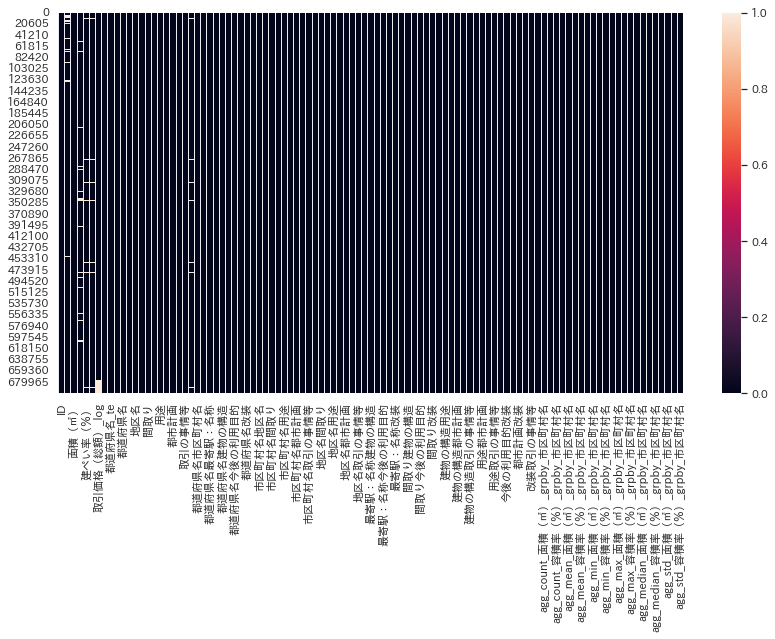

In [31]:
# 欠損値の可視化
plt.figure(figsize=(14,7))
sns.heatmap(feat_df.isnull())

## EDA

In [33]:
!pip install sweetviz

     |████████████████████████████████| 15.1 MB 6.9 MB/s 


In [34]:
train_df = feat_df.iloc[:val_min_idx, :]
val_df = feat_df.iloc[val_min_idx:test_min_idx, :]
test_df = feat_df.iloc[test_min_idx:, :]
print(train_df.shape, val_df.shape, test_df.shape)

(652493, 101) (24899, 101) (23151, 101)


In [ ]:
import sweetviz as sv

my_report = sv.compare([train_df, "Train"], [val_df, "Test"], TARGET)

#直接ブラウザに表示
my_report.show_html("sweetviz_report_2col.html")

In [38]:
import sweetviz as sv

my_report = sv.compare([train_df, "Train"], [test_df, "Test"])

#直接ブラウザに表示
my_report.show_html("sweetviz_report_2col_2.html")

                                             |          | [  0%]   00:00 -> (? left)

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning:

Glyph 26368 missing from current font.

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning:

Glyph 23492 missing from current font.

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning:

Glyph 39365 missing from current font.

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning:

Glyph 65306 missing from current font.

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning:

Glyph 36317 missing from current font.

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning:

Glyph 38626 missing from current font.

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning:

Glyph 65288 missing from current font.

/usr/local/lib/python3.7/dist-packages/matplotli

Report sweetviz_report_2col_2.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


In [39]:
import sweetviz as sv

my_report = sv.compare([val_df, "Train"], [test_df, "Test"])

#直接ブラウザに表示
my_report.show_html("sweetviz_report_2col_3.html")

                                             |          | [  0%]   00:00 -> (? left)

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning:

Glyph 26368 missing from current font.

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning:

Glyph 23492 missing from current font.

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning:

Glyph 39365 missing from current font.

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning:

Glyph 65306 missing from current font.

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning:

Glyph 36317 missing from current font.

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning:

Glyph 38626 missing from current font.

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning:

Glyph 65288 missing from current font.

/usr/local/lib/python3.7/dist-packages/matplotli

Report sweetviz_report_2col_3.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


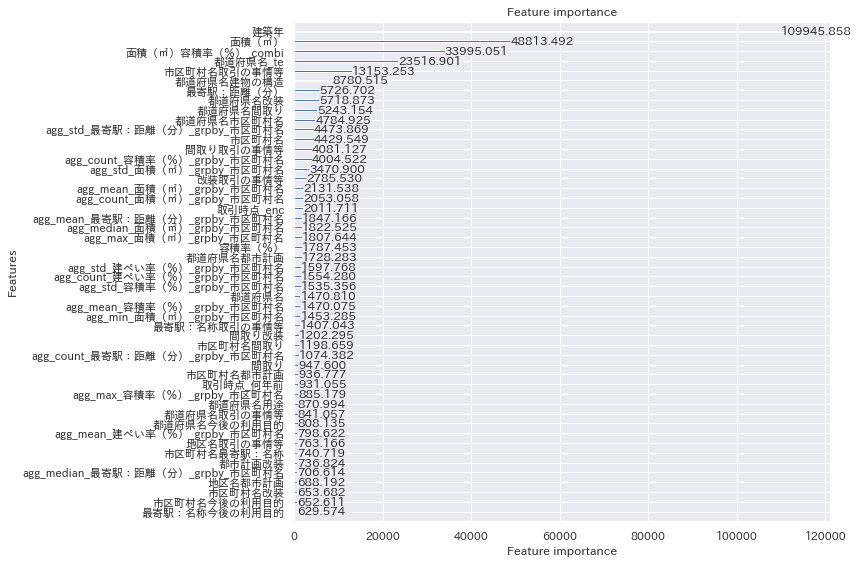

In [ ]:
lgb.plot_importance(optimised_model, figsize=(12,8), max_num_features=50, importance_type='gain')
plt.tight_layout()
plt.savefig(dir_for_output + '/feature_importance.png')
plt.show()
plt.close()

In [ ]:
# LightGBM推論
y_pred = optimised_model.predict(test_x)

In [ ]:
test_df[TARGET] = y_pred

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
sub_df = pd.merge(sub_df[['ID']], test_df[['ID', TARGET]], on='ID')
sub_df.to_csv(dir_for_output + '/test_submission.csv', index=False)

In [ ]:
# モデルを保存する
import pickle

file = 'trained_model.pkl'
pickle.dump(optimised_model, open(dir_for_output + "/" + file, 'wb'))